# **1. Обзор данных.**

- ***Описание датасета*** 



- **Home Ownership** - домовладение   
- **Annual incom**e - годовой доход            
-   **Years in** **current** **job** - количество лет на текущем месте работы
-   **Tax Liens** - налоговые обременения                   
-   **Number of Open Accounts** - количество открытых счетов      
-   **Years of Credit History** - количество лет кредитной истории      
-   **Maximum Open Credit** - наибольший открытый кредит          
-   **Number of Credit Problems** - количество проблем с кредитом    
-   **Months since last delinquent** - количество месяцев с последней просрочки платежа 
-   **Bankruptcies** - банкротства                
-  **Purpose** - цель кредита                      
-  **Term** - срок кредита                          
-  **Current Loan Amount** - текущая сумма кредита          
-  **Current Credit Balance** - текущий кредитный баланс      
-  **Monthly Debt** - ежемесячный долг                 
-  **Credit Score** - кредитный рейтинг              
-  **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)




### **Путь к директориям и файлам.**

In [9]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

*   ***Импорт библиотек и скриптов***

In [10]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
import warnings
warnings.simplefilter('ignore')

In [12]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [13]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [16]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [17]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### **Загрузка данных.**

In [1252]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [1253]:
df_train.shape

(7500, 17)

In [1254]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [1255]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [1256]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [1257]:
df_test.shape

(2500, 16)

- ***Уменьшение объема датасета***

In [1258]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [1259]:
df_test.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [1260]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [1261]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


###  **Обзор количественных переменных.**

In [1262]:
df_train_num_features = df_train.select_dtypes(include=['float32', 'int8'])
df_train_num_features.drop('Credit Default', axis=1, inplace=True)

In [1263]:
num_features_list = df_train_num_features.columns.to_list()

In [1264]:
df_train_num_features.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130934,18.317467,9.451538e+05,0.170000,34.692600,0.117152,11873178.0,2.898332e+05,18314.453125,1151.087524
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688807,0.347192,31926124.0,3.178714e+05,11926.764648,1604.451416
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.000000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.000000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b8eb47ca0>,
      dtype=object)

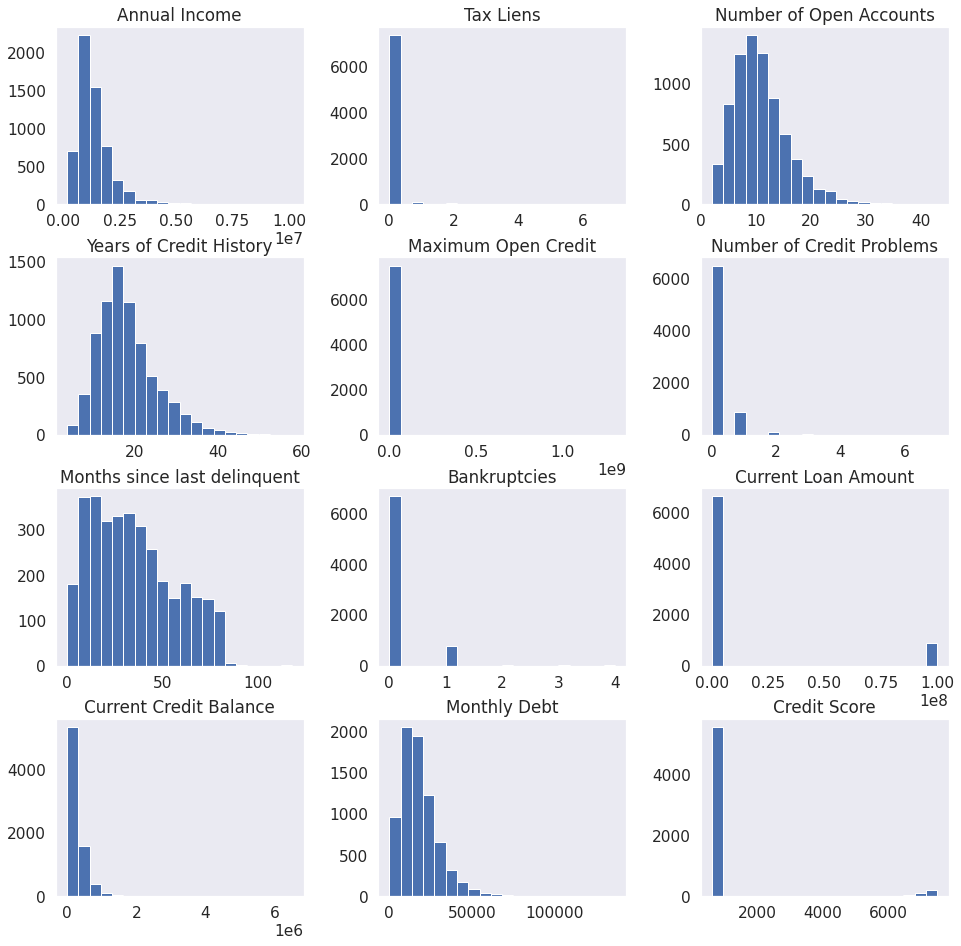

In [1265]:
df_train_num_features.hist(figsize=(16,16), bins=20, grid=False)

### **Обзор номинативных переменных.**

In [1266]:
df_train_obj = df_train.select_dtypes(include=('object', 'category'))

df_train_obj.head()

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,NaN,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term


In [1267]:
df_train_cat_names = df_train_obj.columns.to_list()

In [1268]:
df_train_obj.dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

# **2. Обработка выбросов.**

In [1269]:
outliers_list = ['Credit Score', 'Current Loan Amount', 'Current Credit Balance', 'Maximum Open Credit']

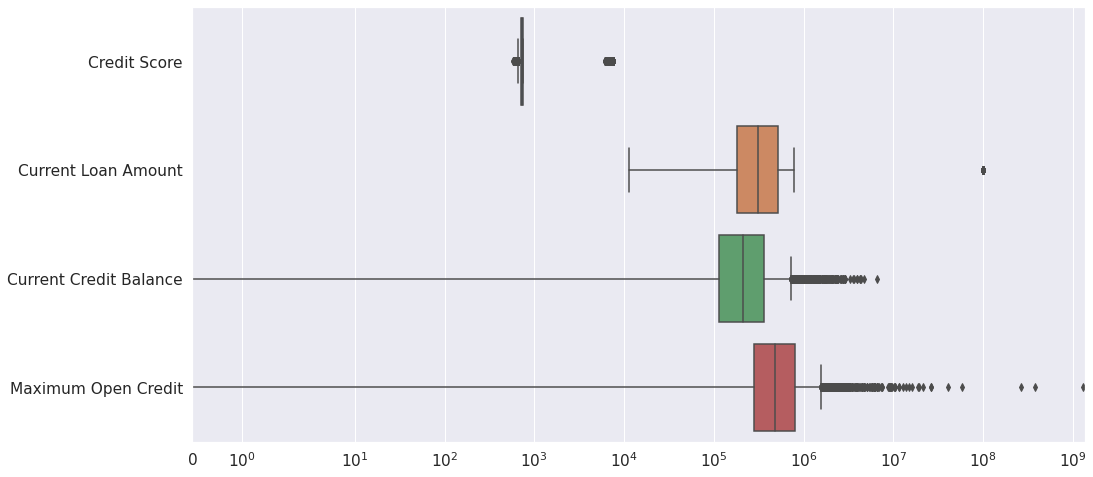

In [1270]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_train[outliers_list], orient='h')
plt.xscale('symlog')
plt.xlim(left=0)
plt.show()

- Credit Score

In [1271]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
616.0       1
6600.0      1
629.0       1
6820.0      1
6060.0      1
Name: Credit Score, Length: 268, dtype: int64

In [1272]:
hhh = df_train.loc[(df_train['Credit Score'] > 6000), 'Credit Score']
df_train.loc[(df_train['Credit Score'] > 6000), 'Credit Score'] = hhh // 10

- *Current Loan Amount*

In [1273]:
df_train['Current Loan Amount'].value_counts()

100000000.0    870
218064.0         6
89298.0          6
222926.0         5
265826.0         5
              ... 
351626.0         1
212498.0         1
187682.0         1
108922.0         1
26928.0          1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [1274]:
df_train.loc[(df_train['Current Loan Amount'] >= 99999999.0), 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

In [1275]:
df_train['Current Loan Amount'].value_counts()

309573.0    870
218064.0      6
89298.0       6
222926.0      5
265826.0      5
           ... 
351626.0      1
212498.0      1
187682.0      1
108922.0      1
26928.0       1
Name: Current Loan Amount, Length: 5386, dtype: int64

- *Current Credit Balance*

In [1276]:
df_train['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
106818.0     4
83638.0      4
136401.0     4
            ..
445360.0     1
243371.0     1
25688.0      1
62054.0      1
288192.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

In [1277]:
df_train.loc[(df_train['Current Credit Balance'] == 0.0), 'Current Credit Balance'] = df_train['Current Credit Balance'].median()

- *Maximum Open Credit*

In [1278]:
df_train['Maximum Open Credit'].value_counts()

0.0         65
319110.0     5
246224.0     3
344058.0     3
513524.0     3
            ..
668360.0     1
642224.0     1
779372.0     1
372812.0     1
480832.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [1279]:
df_train.loc[(df_train['Maximum Open Credit'] == 0.0), 'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()

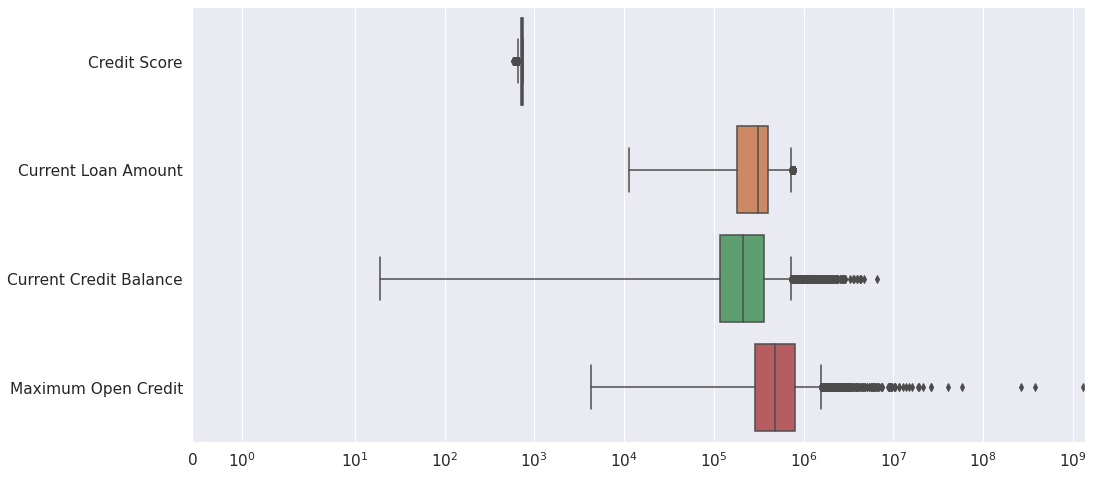

In [1280]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_train[outliers_list], orient='h')
plt.xscale('symlog')
plt.xlim(left=0)
plt.show()

# **3. Обработка пропусков.**

In [1281]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

- *Annual Income*

In [1282]:
df_train['Annual Income'] = df_train['Annual Income'].fillna(df_train['Annual Income'].median())


- *Credit Score*

In [1283]:
df_train['Credit Score'] = df_train['Credit Score'].fillna(df_train['Credit Score'].median())

- *Months since last delinquent*

In [1284]:
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].fillna(method='bfill')

- *Years in current job*

In [1285]:
df_train['Years in current job'] = df_train['Years in current job'].fillna(method='ffill')

In [1286]:
df_train.isna().sum()

Home Ownership                   0
Annual Income                    0
Years in current job             1
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     3
Bankruptcies                    14
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
Credit Default                   0
dtype: int64

# **4. Обзор целевой переменной.**

- *Распределение*

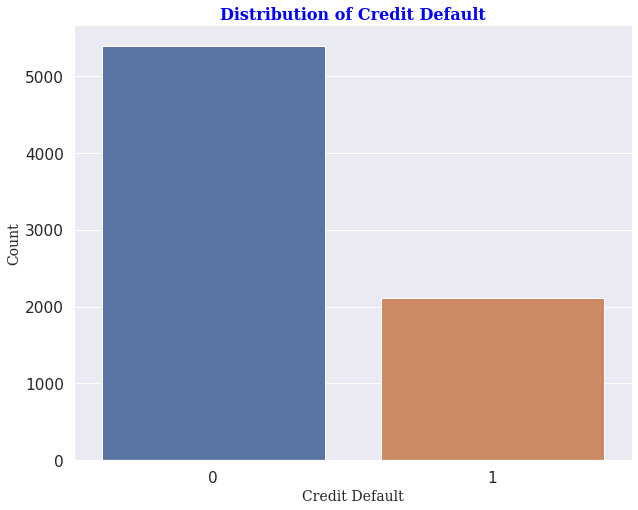

In [1287]:
plt.figure(figsize = (10, 8))
label_font = {
    "fontsize": 14,
    "family": "serif",
}
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "blue",
    "family": "serif"
}

sns.countplot(x='Credit Default', data=df_train)
plt.ylabel('Count', fontdict=label_font)
plt.xlabel('Credit Default', fontdict=label_font)

plt.title('Distribution of Credit Default', fontdict=title_font)
plt.show()

In [1288]:
BASE_FEATURE_NAMES = df_train.columns.drop('Credit Default').tolist()

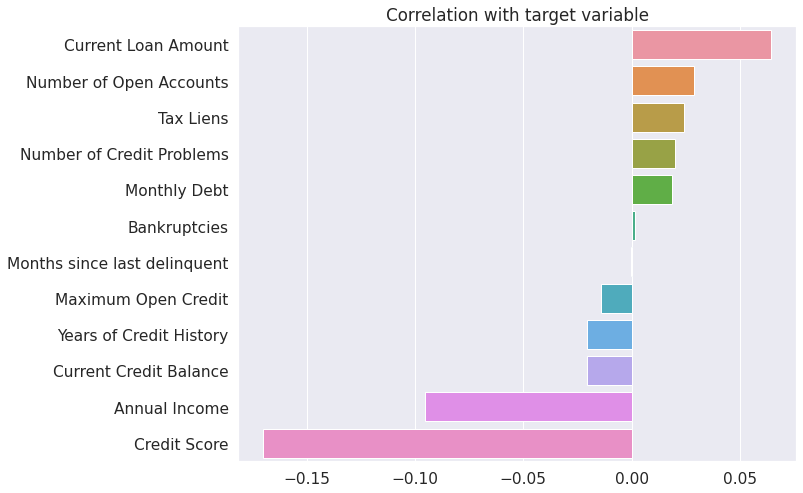

In [1289]:
corr_with_target = df_train[BASE_FEATURE_NAMES + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

- *Создание матрицы корреляций*

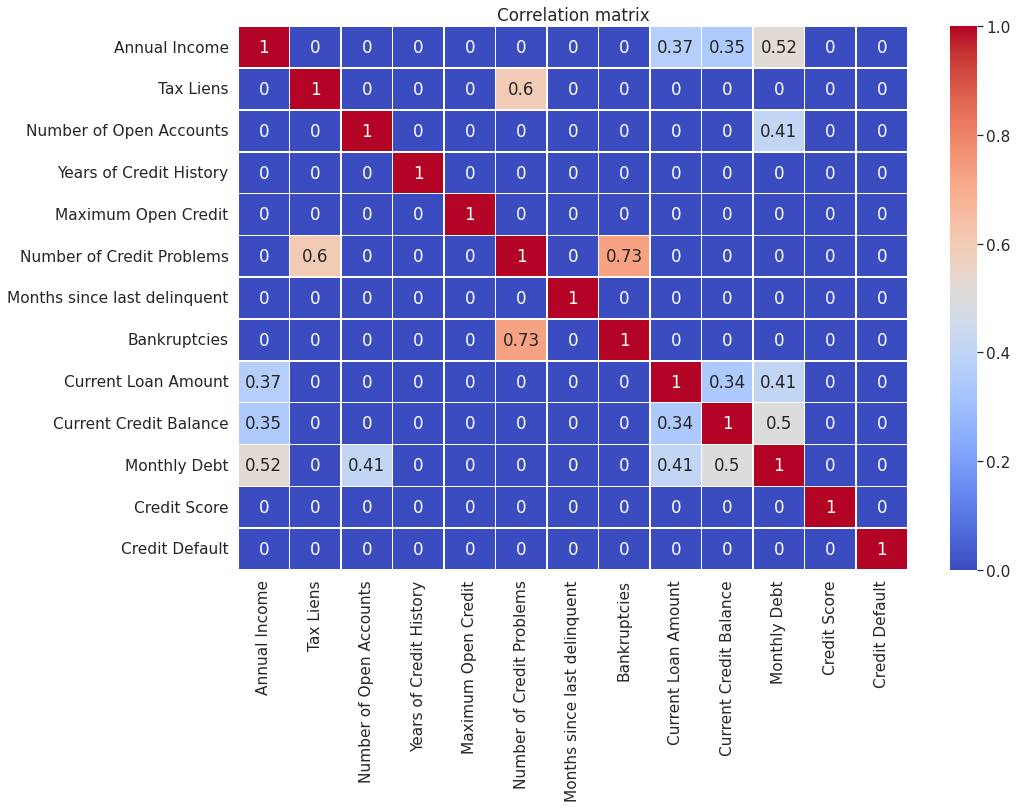

In [1290]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# **4. Нормализация данных.**

In [1291]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[num_features_list] = scaler.fit_transform(df_norm[num_features_list])

df_train = df_norm.copy()


# **5. Балансировка классов.**

- *Перевод категориальных переменных в бинарные.*

In [1292]:
columns_obj = df_train.select_dtypes('category').columns
df_train = pd.get_dummies(df_train, columns=columns_obj)

In [1293]:
TARGET_NAME = 'Credit Default'

In [1294]:
new_names_list = ['Annual Income',  'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
        'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 
       'Home Ownership_Home Mortgage', 
       'Home Ownership_Rent', 'Years in current job_1 year', 
       'Years in current job_10+ years', 
       'Purpose_debt consolidation', 
       'Term_Long Term', 'Credit Default']

In [1295]:
d = df_train.copy()
df_for_balancing = d[new_names_list]
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

# **6. Построение модели.**

In [1296]:
X = df_balanced.drop([TARGET_NAME], axis=1)
y = df_balanced[TARGET_NAME]

In [1297]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [1298]:
model_lgbm = lgbm.LGBMClassifier(objective="binary", n_estimators=600, random_state=12)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3652
           1       1.00      1.00      1.00      2788

    accuracy                           1.00      6440
   macro avg       1.00      1.00      1.00      6440
weighted avg       1.00      1.00      1.00      6440

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1735
           1       0.76      0.77      0.76      1438

    accuracy                           0.79      3173
   macro avg       0.78      0.78      0.78      3173
weighted avg       0.79      0.79      0.79      3173

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1389   346
1                334  1104


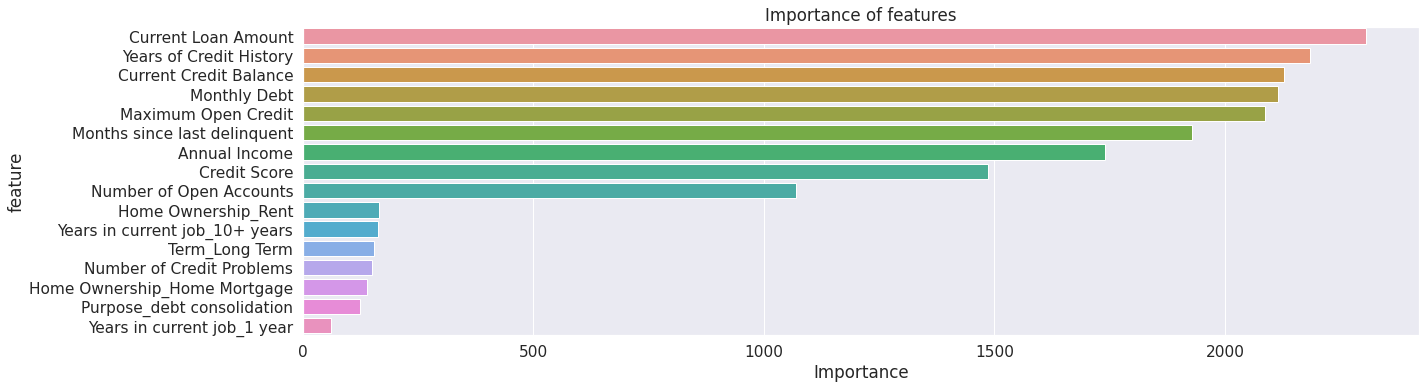

In [1299]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_, get_top=15)

In [1300]:
show_learning_curve_plot(model_lgbm, X, y)

- *Кросс-валидация*

In [1301]:
cv_score = cross_val_score(model_lgbm, X, y, scoring='f1', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76292212, 0.75959169, 0.78726287])

# **7. Прогнозирование на тестовом датасете.**

In [1302]:
class FeaturesGenerator():
    
    def __init__(self):
        
        self.cat_columns=None
        
        
    def transform(self,df):
        
        # Корректируем выбросные значения
        
        h = df.loc[(df['Credit Score'] > 6000), 'Credit Score']
        df.loc[(df['Credit Score'] > 6000), 'Credit Score'] = h // 10
        df.loc[(df['Current Loan Amount'] >= 999999.0), 'Current Loan Amount'] = df['Current Loan Amount'].median()
        df.loc[(df['Current Credit Balance'] == 0.0), 'Current Credit Balance'] = df['Current Credit Balance'].median()
        df.loc[(df['Maximum Open Credit'] == 0.0), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()       
              
        # Корректируем пропуски
        
        df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())
        df['Credit Score'] = df['Credit Score'].fillna(df_train['Credit Score'].median())
        df['Months since last delinquent'] = df['Months since last delinquent'].fillna(method='bfill')
        df['Years in current job'] = df['Years in current job'].fillna(method='ffill')
        
        # Назначаем столбцы для последующего дамми-кодирования. Кодируем категориальные переменные
        
        self.cat_columns=df.select_dtypes('category').columns
        df=pd.get_dummies(df, columns=self.cat_columns)
           
        
        return df

In [1303]:
generator = FeaturesGenerator()
df_test = generator.transform(df_test)

In [1304]:
predictions = model_lgbm.predict(df_test[new_names_list[:-1]])

In [1305]:
index = [i for i in range(0, len(predictions))]

In [1306]:
result=pd.DataFrame({'Id':index, 'Credit Default':predictions})

In [1307]:
#result.to_csv('AA_Ivina_predictions.csv',  sep=',', index=False)